In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState

In [ ]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# LOAD AND PROCESS DATA
**EXAMPLE WITH ADULT INCOME DATASET**
1. Divide features into a set of numerical and a set of categorical.
1. Retrieve class counts for each categorical feature (will be used later down the line)
1. Standardize or perform quantile transformations to numerical/continuous features.
1. Wrap with Dataset and Dataloader.

In [ ]:
# df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/train.csv')
# df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/test.csv')
# df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/validation.csv') #READ FROM RIGHT SPOT

df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\train.csv')
df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\test.csv')
df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\validation.csv') #READ FROM RIGHT SPOT

#Take a look at what the datasets look like initially to get an idea
df_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,19,9,171578,15,10,4,15,3,2,1,0,0,40,39,0
1,32,4,281030,11,9,2,7,0,4,1,0,0,40,39,0
2,43,4,75993,15,10,2,12,0,4,1,7688,0,40,39,1
3,37,4,37238,9,13,4,4,1,4,1,0,0,45,39,0
4,42,1,25240,8,11,0,10,4,0,0,0,0,40,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34184,35,4,200117,9,13,2,4,0,1,1,0,1887,50,0,1
34185,21,4,90896,11,9,4,7,3,4,0,0,0,40,39,0
34186,23,4,370057,11,9,0,1,1,4,0,0,0,40,39,0
34187,18,4,216284,1,7,4,1,3,4,0,0,0,20,39,0


In [ ]:
#Take a look at the feature names
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [ ]:
# Divide the features up (DO THIS MANUALLY TO ENSURE YOU SEPERATE THEM HOW YOU NEED)

#SET cat-columns TO NONE IF THERE ARE NO CATEGORICAL FEATURES
cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
target = ['income']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cat_columns + cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

In [ ]:
#Get class counts and store in a list below

for x in cat_columns:
    print(max(len(df_train[x].value_counts()), len(df_val[x].value_counts()), len(df_test[x].value_counts())))

10
16
7
16
6
5
2
43


In [ ]:
cat_feat = [10,16,7,16,6,5,2,43]

In [ ]:
#Getting the number of classes in your classification target
target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]

In [ ]:
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

In [ ]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_columns, cont_columns, 'income')
val_dataset = SingleTaskDataset(df_val, cat_columns, cont_columns, 'income')
test_dataset = SingleTaskDataset(df_test, cat_columns, cont_columns, 'income')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# MODEL AND HELPERS

1. All you should have to do is interact with Classifier()

In [ ]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_cont, cat_feat, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.cont_embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):

            goin_in = cat_x[:,i,:]
  
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_cont = 0,
                 cat_feat:list = [],
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     embedding_dropout=embedding_dropout,n_cont=n_cont, cat_feat=cat_feat, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, cat_x, cont_x):
        class_embed, context = self.embeddings(cat_x, cont_x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

# RUN EXPERIMENTS

1. Using Optuna to optimize CAT-Transformers hyperparameters for your dataset

In [42]:
# Define the early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_metric = float('-inf')
        self.early_stop = False

    def __call__(self, metric):
        if metric > self.best_metric:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to log results to a text file
def log_to_file(filename, text):
    with open(filename, 'a') as f:
        f.write(text + '\n')

def objective(trial):
    trial_number = trial.number

    # Define hyperparameters to search over
    sigma = trial.suggest_categorical('sigma', [.001, 0.1, 1, 2, 3, 5, 10])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    # Ensure that embed_size is divisible by num_layers
    embed_size = trial.suggest_categorical("embed_size", [50,100,150,180,200,250,300])
    heads = trial.suggest_categorical("heads", [1, 5, 10])
    forward_expansion = trial.suggest_int('forward_expansion', 1, 10)
    prenorm_on = trial.suggest_categorical('prenorm_on', [True, False])
    mlp_scale_classification = trial.suggest_int('mlp_scale_classification', 1, 10)
    embedding_dropout = trial.suggest_categorical('embedding_dropout', [0, .1, .2, .5])
    decoder_dropout = trial.suggest_categorical('decoder_dropout', [0,.1,.2,.5])
    classification_dropout = trial.suggest_categorical('class_drop', [0,.1,.2,.5])

    learning_rate = trial.suggest_categorical('learning_rate', [0.00001,0.0001, 0.001, 0.01])

    num_epochs = 75

    # Create your model with the sampled hyperparameters
    model = Classifier(
        targets_classes=target_classes,
        rff_on=True, #LEAVING ON
        n_cont=len(cont_columns),
        cat_feat=cat_feat,
        sigma=sigma,
        embed_size=embed_size,
        num_layers=num_layers,
        heads=heads,
        forward_expansion=forward_expansion,
        pre_norm_on=prenorm_on,
        mlp_scale_classification=mlp_scale_classification,
        embedding_dropout=embedding_dropout,
        decoder_dropout=decoder_dropout,
        classification_dropout=classification_dropout
    ).to(device_in_use)

    # Define loss function and optimizer
    loss_function = UncertaintyLoss(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3)  # Adjust patience as needed

    # Training loop with a large number of epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(train_dataloader, model, loss_function, optimizer, device_in_use)
        
        # Validation loop
        val_loss, val_accuracy, _, _, _ = test(val_dataloader, model, loss_function, device_in_use)
        
        # Check if we should early stop based on validation accuracy
        if early_stopping(val_accuracy):
            break

    
    # Log the final test accuracy for this trial to a shared log file
    final_log = f"Trial {trial_number} completed. Validation Accuracy = {val_accuracy:.4f}"
    log_to_file('all_trials_log.txt', final_log)

    # Return the test accuracy as the objective to optimize
    return val_accuracy

In [43]:
# Set the number of optimization trials
num_trials = 50

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize validation accuracy

# Start the optimization process
study.optimize(objective, n_trials=num_trials, show_progress_bar=True)

# Get the best hyperparameters and the validation accuracy at the point of early stopping
best_params = study.best_params
best_val_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy (at Early Stopping):", best_val_accuracy)

[I 2023-11-04 12:58:58,528] A new study created in memory with name: no-name-502c49a1-b21d-4ad3-ae37-46b71eb59094
Best trial: 0. Best value: 0.85668:   2%|▏         | 1/50 [03:14<2:38:35, 194.19s/it]

[I 2023-11-04 13:02:12,728] Trial 0 finished with value: 0.8566797474833646 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 100, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 9, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 1e-05}. Best is trial 0 with value: 0.8566797474833646.


Best trial: 1. Best value: 0.865381:   4%|▍         | 2/50 [05:36<2:10:58, 163.72s/it]

[I 2023-11-04 13:04:35,111] Trial 1 finished with value: 0.8653813342433032 and parameters: {'sigma': 1, 'num_layers': 2, 'embed_size': 100, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 1, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.8653813342433032.


Best trial: 1. Best value: 0.865381:   6%|▌         | 3/50 [07:49<1:57:06, 149.50s/it]

[I 2023-11-04 13:06:47,688] Trial 2 finished with value: 0.8283569356765057 and parameters: {'sigma': 0.001, 'num_layers': 2, 'embed_size': 100, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 1 with value: 0.8653813342433032.


Best trial: 3. Best value: 0.866917:   8%|▊         | 4/50 [09:51<1:46:20, 138.71s/it]

[I 2023-11-04 13:08:49,863] Trial 3 finished with value: 0.86691690837741 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 150, 'heads': 5, 'forward_expansion': 9, 'prenorm_on': True, 'mlp_scale_classification': 10, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 3 with value: 0.86691690837741.


Best trial: 3. Best value: 0.866917:  10%|█         | 5/50 [11:58<1:40:55, 134.56s/it]

[I 2023-11-04 13:10:57,048] Trial 4 finished with value: 0.8597508957515783 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 100, 'heads': 10, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 1e-05}. Best is trial 3 with value: 0.86691690837741.


Best trial: 3. Best value: 0.866917:  12%|█▏        | 6/50 [13:54<1:33:55, 128.08s/it]

[I 2023-11-04 13:12:52,565] Trial 5 finished with value: 0.8616277085821532 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 200, 'heads': 10, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0.1, 'learning_rate': 1e-05}. Best is trial 3 with value: 0.86691690837741.


Best trial: 3. Best value: 0.866917:  14%|█▍        | 7/50 [16:03<1:32:04, 128.47s/it]

[I 2023-11-04 13:15:01,834] Trial 6 finished with value: 0.8641869988056645 and parameters: {'sigma': 3, 'num_layers': 2, 'embed_size': 100, 'heads': 10, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 10, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 3 with value: 0.86691690837741.


Best trial: 3. Best value: 0.866917:  16%|█▌        | 8/50 [18:12<1:30:05, 128.71s/it]

[I 2023-11-04 13:17:11,061] Trial 7 finished with value: 0.7589148609452312 and parameters: {'sigma': 5, 'num_layers': 2, 'embed_size': 150, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 3 with value: 0.86691690837741.


Best trial: 3. Best value: 0.866917:  18%|█▊        | 9/50 [20:07<1:24:56, 124.30s/it]

[I 2023-11-04 13:19:05,679] Trial 8 finished with value: 0.8604333731445146 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 200, 'heads': 10, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.001}. Best is trial 3 with value: 0.86691690837741.


Best trial: 9. Best value: 0.867599:  20%|██        | 10/50 [22:18<1:24:21, 126.55s/it]

[I 2023-11-04 13:21:17,252] Trial 9 finished with value: 0.8675993857703463 and parameters: {'sigma': 2, 'num_layers': 2, 'embed_size': 180, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 9 with value: 0.8675993857703463.


Best trial: 9. Best value: 0.867599:  22%|██▏       | 11/50 [24:31<1:23:34, 128.59s/it]

[I 2023-11-04 13:23:30,467] Trial 10 finished with value: 0.8628220440197918 and parameters: {'sigma': 2, 'num_layers': 2, 'embed_size': 180, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 9 with value: 0.8675993857703463.


Best trial: 9. Best value: 0.867599:  24%|██▍       | 12/50 [26:32<1:19:56, 126.23s/it]

[I 2023-11-04 13:25:31,306] Trial 11 finished with value: 0.8626514246715578 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 250, 'heads': 5, 'forward_expansion': 9, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 9 with value: 0.8675993857703463.


Best trial: 9. Best value: 0.867599:  26%|██▌       | 13/50 [29:05<1:22:50, 134.34s/it]

[I 2023-11-04 13:28:04,288] Trial 12 finished with value: 0.8664050503327078 and parameters: {'sigma': 2, 'num_layers': 2, 'embed_size': 50, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 9 with value: 0.8675993857703463.


Best trial: 13. Best value: 0.869988:  28%|██▊       | 14/50 [31:05<1:17:57, 129.94s/it]

[I 2023-11-04 13:30:04,049] Trial 13 finished with value: 0.8699880566456236 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 150, 'heads': 5, 'forward_expansion': 10, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 13 with value: 0.8699880566456236.


Best trial: 14. Best value: 0.871865:  30%|███       | 15/50 [32:58<1:12:51, 124.89s/it]

[I 2023-11-04 13:31:57,228] Trial 14 finished with value: 0.8718648694761986 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 180, 'heads': 5, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  32%|███▏      | 16/50 [34:58<1:09:54, 123.36s/it]

[I 2023-11-04 13:33:57,048] Trial 15 finished with value: 0.8425183415799352 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 300, 'heads': 5, 'forward_expansion': 10, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  34%|███▍      | 17/50 [36:51<1:06:09, 120.30s/it]

[I 2023-11-04 13:35:50,227] Trial 16 finished with value: 0.8689643405562191 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  36%|███▌      | 18/50 [38:52<1:04:17, 120.54s/it]

[I 2023-11-04 13:37:51,313] Trial 17 finished with value: 0.8571916055280668 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 180, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 4, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  38%|███▊      | 19/50 [40:48<1:01:32, 119.12s/it]

[I 2023-11-04 13:39:47,146] Trial 18 finished with value: 0.7561849513734857 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 250, 'heads': 5, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 6, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  40%|████      | 20/50 [42:53<1:00:21, 120.72s/it]

[I 2023-11-04 13:41:51,589] Trial 19 finished with value: 0.8578740829210032 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 50, 'heads': 1, 'forward_expansion': 9, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  42%|████▏     | 21/50 [44:50<57:49, 119.65s/it]  

[I 2023-11-04 13:43:48,734] Trial 20 finished with value: 0.8597508957515783 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 300, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 6, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  44%|████▍     | 22/50 [46:48<55:35, 119.13s/it]

[I 2023-11-04 13:45:46,651] Trial 21 finished with value: 0.8703292953420918 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  46%|████▌     | 23/50 [48:51<54:07, 120.28s/it]

[I 2023-11-04 13:47:49,605] Trial 22 finished with value: 0.8696468179491554 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  48%|████▊     | 24/50 [50:49<51:51, 119.67s/it]

[I 2023-11-04 13:49:47,856] Trial 23 finished with value: 0.8681112438150487 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 9, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 14. Best value: 0.871865:  50%|█████     | 25/50 [52:47<49:41, 119.26s/it]

[I 2023-11-04 13:51:46,157] Trial 24 finished with value: 0.8051527043166695 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 180, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8718648694761986.


Best trial: 25. Best value: 0.87323:  52%|█████▏    | 26/50 [54:44<47:27, 118.64s/it] 

[I 2023-11-04 13:53:43,340] Trial 25 finished with value: 0.8732298242620713 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  54%|█████▍    | 27/50 [56:37<44:50, 116.96s/it]

[I 2023-11-04 13:55:36,387] Trial 26 finished with value: 0.8633339020644941 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.1, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 1e-05}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  56%|█████▌    | 28/50 [58:34<42:51, 116.90s/it]

[I 2023-11-04 13:57:33,170] Trial 27 finished with value: 0.7643746800887221 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 180, 'heads': 1, 'forward_expansion': 9, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  58%|█████▊    | 29/50 [1:00:26<40:26, 115.54s/it]

[I 2023-11-04 13:59:25,517] Trial 28 finished with value: 0.7862139566626856 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  60%|██████    | 30/50 [1:02:21<38:26, 115.35s/it]

[I 2023-11-04 14:01:20,419] Trial 29 finished with value: 0.7560143320252517 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 200, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 1e-05}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  62%|██████▏   | 31/50 [1:04:18<36:37, 115.68s/it]

[I 2023-11-04 14:03:16,850] Trial 30 finished with value: 0.8614570892339192 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 50, 'heads': 1, 'forward_expansion': 9, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  64%|██████▍   | 32/50 [1:06:14<34:47, 115.96s/it]

[I 2023-11-04 14:05:13,484] Trial 31 finished with value: 0.8679406244668145 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 150, 'heads': 5, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  66%|██████▌   | 33/50 [1:08:11<32:52, 116.04s/it]

[I 2023-11-04 14:07:09,700] Trial 32 finished with value: 0.8677700051185805 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': True, 'mlp_scale_classification': 2, 'embedding_dropout': 0.2, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  68%|██████▊   | 34/50 [1:10:11<31:17, 117.32s/it]

[I 2023-11-04 14:09:10,002] Trial 33 finished with value: 0.8646988568503668 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 150, 'heads': 5, 'forward_expansion': 9, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  70%|███████   | 35/50 [1:12:09<29:23, 117.54s/it]

[I 2023-11-04 14:11:08,063] Trial 34 finished with value: 0.8667462890291759 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 150, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  72%|███████▏  | 36/50 [1:14:24<28:36, 122.64s/it]

[I 2023-11-04 14:13:22,595] Trial 35 finished with value: 0.8640163794574305 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 300, 'heads': 10, 'forward_expansion': 9, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  74%|███████▍  | 37/50 [1:16:21<26:14, 121.09s/it]

[I 2023-11-04 14:15:20,063] Trial 36 finished with value: 0.855485412045726 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 250, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': True, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  76%|███████▌  | 38/50 [1:18:17<23:52, 119.40s/it]

[I 2023-11-04 14:17:15,548] Trial 37 finished with value: 0.8493431155092988 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 100, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  78%|███████▊  | 39/50 [1:20:14<21:46, 118.78s/it]

[I 2023-11-04 14:19:12,863] Trial 38 finished with value: 0.857362224876301 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 150, 'heads': 10, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.1, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 1e-05}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  80%|████████  | 40/50 [1:22:25<20:23, 122.37s/it]

[I 2023-11-04 14:21:23,620] Trial 39 finished with value: 0.8635045214127282 and parameters: {'sigma': 1, 'num_layers': 2, 'embed_size': 180, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  82%|████████▏ | 41/50 [1:24:33<18:37, 124.18s/it]

[I 2023-11-04 14:23:32,000] Trial 40 finished with value: 0.8513905476881078 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 150, 'heads': 10, 'forward_expansion': 9, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  84%|████████▍ | 42/50 [1:27:00<17:28, 131.05s/it]

[I 2023-11-04 14:25:59,117] Trial 41 finished with value: 0.8653813342433032 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  86%|████████▌ | 43/50 [1:28:53<14:39, 125.68s/it]

[I 2023-11-04 14:27:52,251] Trial 42 finished with value: 0.86691690837741 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  88%|████████▊ | 44/50 [1:30:49<12:16, 122.80s/it]

[I 2023-11-04 14:29:48,325] Trial 43 finished with value: 0.8682818631632827 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 10, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  90%|█████████ | 45/50 [1:32:42<09:58, 119.78s/it]

[I 2023-11-04 14:31:41,076] Trial 44 finished with value: 0.8718648694761986 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 200, 'heads': 1, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  92%|█████████▏| 46/50 [1:34:38<07:54, 118.58s/it]

[I 2023-11-04 14:33:36,842] Trial 45 finished with value: 0.7921856338508787 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 200, 'heads': 1, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  94%|█████████▍| 47/50 [1:36:46<06:04, 121.44s/it]

[I 2023-11-04 14:35:44,966] Trial 46 finished with value: 0.8689643405562191 and parameters: {'sigma': 5, 'num_layers': 2, 'embed_size': 200, 'heads': 5, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 2, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  96%|█████████▌| 48/50 [1:38:41<03:59, 119.64s/it]

[I 2023-11-04 14:37:40,398] Trial 47 finished with value: 0.7561849513734857 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 200, 'heads': 1, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.01}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323:  98%|█████████▊| 49/50 [1:40:38<01:58, 118.72s/it]

[I 2023-11-04 14:39:36,981] Trial 48 finished with value: 0.8600921344480464 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 100, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 9, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 1e-05}. Best is trial 25 with value: 0.8732298242620713.


Best trial: 25. Best value: 0.87323: 100%|██████████| 50/50 [1:42:33<00:00, 123.07s/it]

[I 2023-11-04 14:41:31,834] Trial 49 finished with value: 0.8703292953420918 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 200, 'heads': 10, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 25 with value: 0.8732298242620713.
Best Hyperparameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 150, 'heads': 1, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}
Best Validation Accuracy (at Early Stopping): 0.8732298242620713


Epoch [ 1/75]        | Train: Loss 0.5054, Accuracy 0.7530                               | Test: Loss 0.4757, Accuracy 0.7018, F1 0.7233
Epoch [ 2/75]        | Train: Loss 0.4374, Accuracy 0.7600                               | Test: Loss 0.4563, Accuracy 0.7575, F1 0.7694
Epoch [ 3/75]        | Train: Loss 0.4218, Accuracy 0.7799                               | Test: Loss 0.4302, Accuracy 0.7650, F1 0.7766
Epoch [ 4/75]        | Train: Loss 0.4051, Accuracy 0.7951                               | Test: Loss 0.3693, Accuracy 0.8309, F1 0.8252
Epoch [ 5/75]        | Train: Loss 0.3681, Accuracy 0.8278                               | Test: Loss 0.3408, Accuracy 0.8430, F1 0.8379
Epoch [ 6/75]        | Train: Loss 0.3399, Accuracy 0.8442                               | Test: Loss 0.3353, Accuracy 0.8495, F1 0.8494
Epoch [ 7/75]        | Train: Loss 0.3285, Accuracy 0.8514                               | Test: Loss 0.3257, Accuracy 0.8542, F1 0.8528
Epoch [ 8/75]        | Train: Loss 0.3160

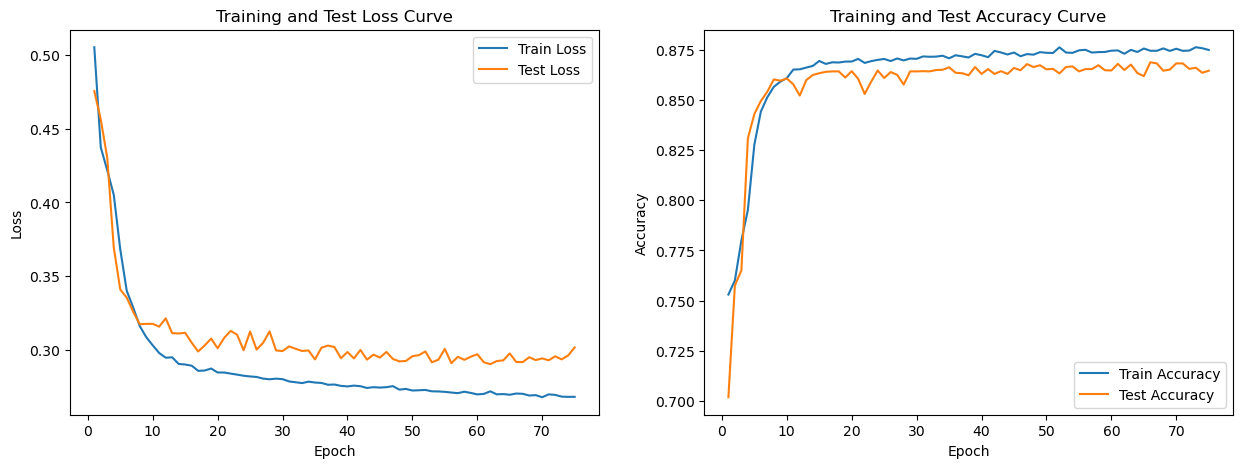

In [44]:
#Testing against the test dataset
model = Classifier(targets_classes=target_classes,
                    rff_on=True,
                    n_cont=len(cont_columns),
                    cat_feat=cat_feat, 
                   sigma=best_params['sigma'],
                   embed_size=best_params['embed_size'],
                   num_layers=best_params['num_layers'],
                   heads=best_params['heads'],
                   forward_expansion=best_params['forward_expansion'],
                   pre_norm_on=best_params['prenorm_on'],
                   mlp_scale_classification=best_params['mlp_scale_classification'],
                   embedding_dropout=best_params['embedding_dropout'],
                   decoder_dropout=best_params['decoder_dropout'],
                   classification_dropout=best_params['class_drop']
                   ).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = best_params['learning_rate']) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
early_stopping = EarlyStopping(patience=3)
epochs = 75 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  if early_stopping(test_accuracy_1):
    break

# Save the model after pre-training
torch.save(model.state_dict(), 'final_model_trained.pth')

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)
